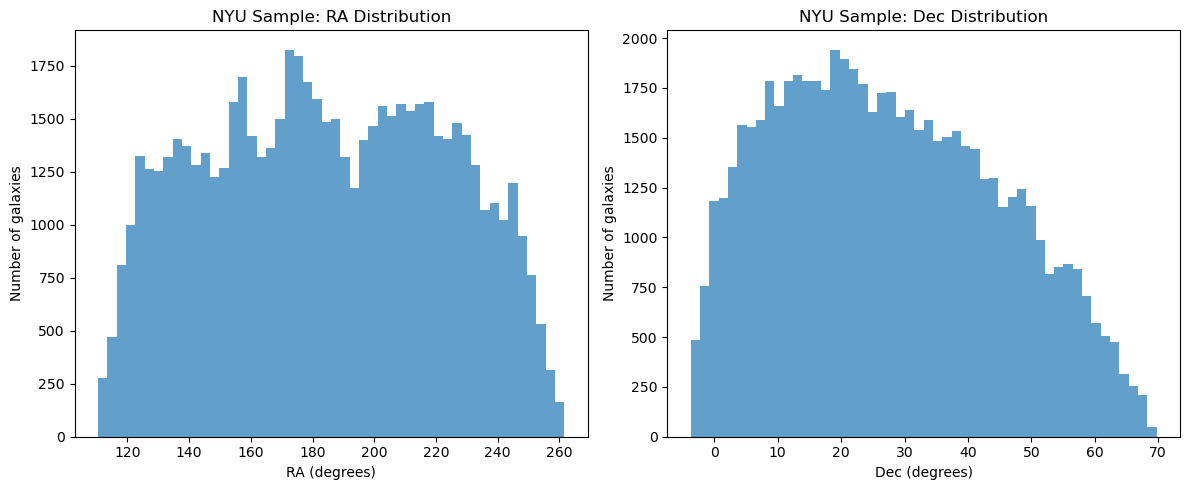

In [1]:
"""
Check declination distribution of SDSS
"""

import numpy as np
import pandas as pd

# ---- Sample----------
sample = 'nyu'
h = 0.6774  # Hubble constant
zmin, zmax = 0.07, 0.2  # Redshift range
mag_max = -21.2
ran_method = 'random_choice'  # ['random_choice', 'piecewise', 'poly']
if ran_method == 'poly':
    deg = 5  # degree of polynomial for redshift distribution fit 
gr_min = 0.8


def load_catalog(sample_name: str) -> pd.DataFrame:
    """Load the requested SDSS-like catalog (logic preserved)."""
    if sample_name == "nyu":
        datafile = "../data/sdss_dr72safe0_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    elif sample_name == "sdss":
        datafile = "../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    else:
        raise ValueError("Invalid sample")

    cat = pd.read_csv(datafile)
    cat["dist_fil"] /= h
    if gr_min != 0:
        cat = cat[cat["gr"] > gr_min]
    return cat


def select_sample(cat: pd.DataFrame) -> pd.DataFrame:
    """Apply redshift and magnitude cuts (preserves original behavior)."""
    cat_z = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
    if sample == "nyu":
        cat_z_mag = cat_z[cat_z["mag_abs_r"] < mag_max].copy()  # <-- add .copy()
    else:
        cat_z_mag = cat_z[cat_z["mag_abs_r"] - 5 * np.log10(h) < mag_max].copy()  # <-- add .copy()
    return cat_z, cat_z_mag

cat_full = load_catalog(sample)
cat_z, cat_z_mag = select_sample(cat_full)

# Plot RA and Dec distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(cat_z_mag["ra"], bins=50, alpha=0.7)
plt.xlabel("RA (degrees)")
plt.ylabel("Number of galaxies")
plt.title(f"{sample.upper()} Sample: RA Distribution")

plt.subplot(1, 2, 2)
plt.hist(cat_z_mag["dec"], bins=50, alpha=0.7)
plt.xlabel("Dec (degrees)")
plt.ylabel("Number of galaxies")
plt.title(f"{sample.upper()} Sample: Dec Distribution")
plt.tight_layout()
plt.show()



Original data: 63164 points
RA range: [110.50, 261.55]
Dec range: [-3.75, 69.78]
Beta fit parameters: a=1.430, b=1.927
Smoothed parameters: a=1.430, b=1.927


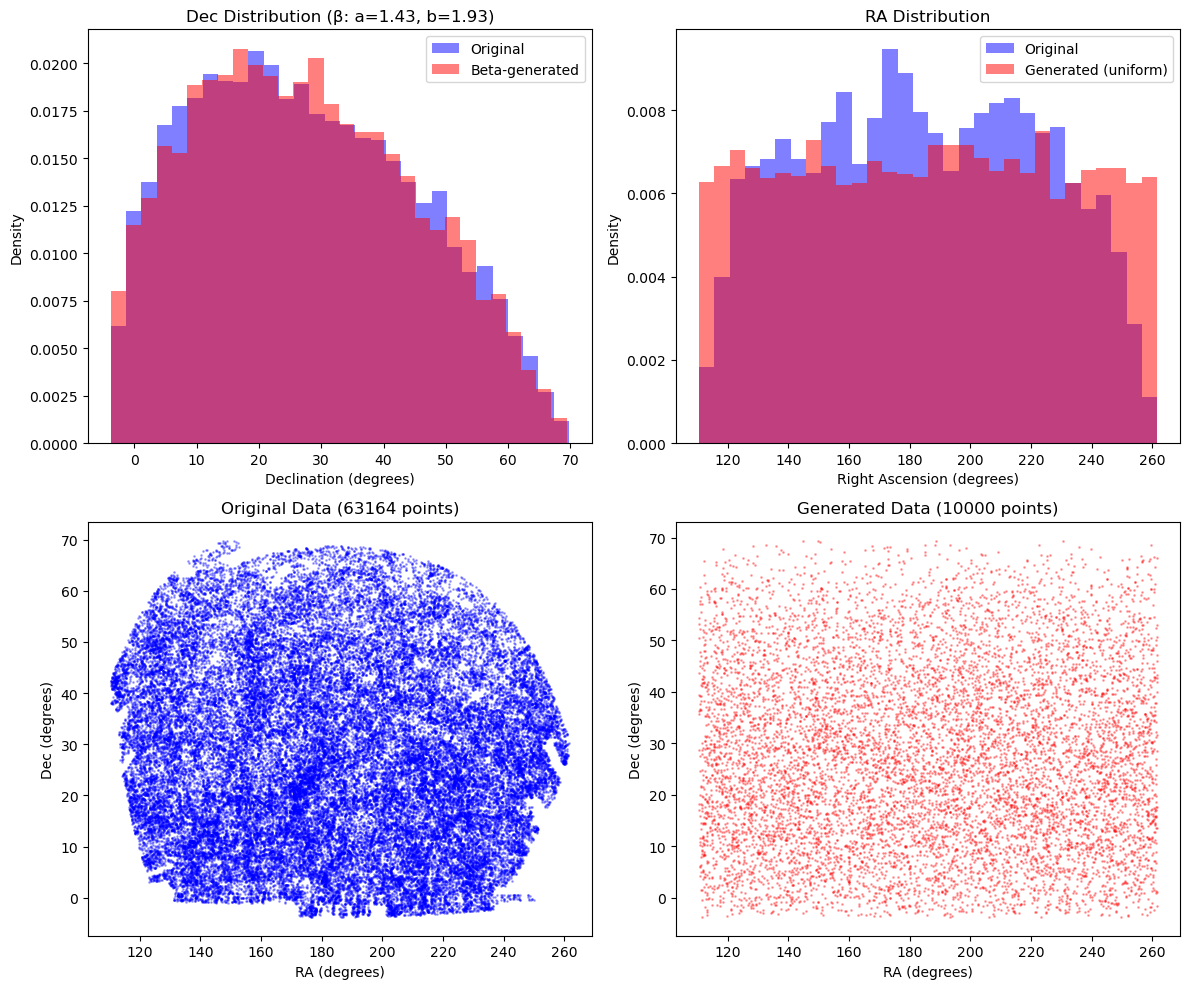


Generated 10000 random points saved to 'random_catalog_beta.csv'


In [2]:
"""
Create smooth random distribution from data using Beta distribution fit
"""

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ---- Sample----------
sample = 'nyu'
h = 0.6774  # Hubble constant
zmin, zmax = 0.07, 0.2  # Redshift range
mag_max = -21.2
ran_method = 'random_choice'  # ['random_choice', 'piecewise', 'poly', 'beta']
if ran_method == 'poly':
    deg = 5  # degree of polynomial for redshift distribution fit 
gr_min = 0.8

# Number of random points to generate
n_random = 10000  # Adjust as needed


def load_catalog(sample_name: str) -> pd.DataFrame:
    """Load the requested SDSS-like catalog (logic preserved)."""
    if sample_name == "nyu":
        datafile = "../data/sdss_dr72safe0_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    elif sample_name == "sdss":
        datafile = "../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    else:
        raise ValueError("Invalid sample")

    cat = pd.read_csv(datafile)
    cat["dist_fil"] /= h
    if gr_min != 0:
        cat = cat[cat["gr"] > gr_min]
    return cat


def select_sample(cat: pd.DataFrame) -> pd.DataFrame:
    """Apply redshift and magnitude cuts (preserves original behavior)."""
    cat_z = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
    if sample == "nyu":
        cat_z_mag = cat_z[cat_z["mag_abs_r"] < mag_max].copy()
    else:
        cat_z_mag = cat_z[cat_z["mag_abs_r"] - 5 * np.log10(h) < mag_max].copy()
    return cat_z, cat_z_mag


def fit_beta_distribution(data, smoothness=1.0):
    """
    Fit a Beta distribution to the data with optional smoothing.
    
    Parameters:
    -----------
    data : array-like
        Input data to fit
    smoothness : float
        Smoothing parameter (1.0 = standard fit, >1 = more peaked, <1 = more uniform)
    
    Returns:
    --------
    function : Inverse CDF function for generating random samples
    tuple : (data_min, data_max) original data range
    tuple : (alpha, beta) fitted parameters
    """
    # Normalize data to [0, 1] range
    data_min, data_max = data.min(), data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    
    # Add small epsilon to avoid 0 and 1 values (Beta distribution requires (0,1))
    eps = 1e-6
    data_norm = np.clip(data_norm, eps, 1 - eps)
    
    # Fit Beta distribution
    a, b, loc, scale = stats.beta.fit(data_norm, floc=0, fscale=1)
    
    # Apply smoothing by adjusting parameters
    # This makes the distribution more/less peaked
    a_smooth = a * smoothness
    b_smooth = b * smoothness
    
    print(f"Beta fit parameters: a={a:.3f}, b={b:.3f}")
    print(f"Smoothed parameters: a={a_smooth:.3f}, b={b_smooth:.3f}")
    
    def inv_cdf_beta(u):
        """Inverse CDF for generating samples."""
        # Generate normalized samples
        samples_norm = stats.beta.ppf(u, a_smooth, b_smooth)
        # Transform back to original scale
        return data_min + samples_norm * (data_max - data_min)
    
    return inv_cdf_beta, (data_min, data_max), (a_smooth, b_smooth)


def generate_random_points(n_points, ra_range, dec_inv_cdf, ra_dist='uniform'):
    """
    Generate random RA/Dec points.
    
    Parameters:
    -----------
    n_points : int
        Number of points to generate
    ra_range : tuple
        (min_ra, max_ra) in degrees
    dec_inv_cdf : function
        Inverse CDF function for Dec distribution
    ra_dist : str
        'uniform' for uniform RA distribution, or 'same' to use same distribution as Dec
    
    Returns:
    --------
    tuple : (ra_random, dec_random)
    """
    if ra_dist == 'uniform':
        # Uniform RA distribution
        ra_random = np.random.uniform(ra_range[0], ra_range[1], n_points)
    else:
        # Use same distribution as Dec (if RA and Dec are correlated)
        u = np.random.uniform(0, 1, n_points)
        ra_random = dec_inv_cdf(u)  # This would need adjustment for RA range
    
    # Generate Dec using inverse transform sampling
    u = np.random.uniform(0, 1, n_points)
    dec_random = dec_inv_cdf(u)
    
    return ra_random, dec_random


# Main execution
if __name__ == "__main__":
    # Load and select data
    cat_full = load_catalog(sample)
    cat_z, cat_z_mag = select_sample(cat_full)
    
    # Extract RA and Dec
    ra = cat_z_mag["ra"].values
    dec = cat_z_mag["dec"].values
    
    print(f"Original data: {len(ra)} points")
    print(f"RA range: [{ra.min():.2f}, {ra.max():.2f}]")
    print(f"Dec range: [{dec.min():.2f}, {dec.max():.2f}]")
    
    # Fit Beta distribution to Dec with smoothing
    smoothness = 1.0  # Adjust this for more/less smoothing (>1 = more peaked, <1 = more uniform)
    dec_inv_cdf, dec_range, beta_params = fit_beta_distribution(dec, smoothness)
    
    # Generate random points
    ra_range = (ra.min(), ra.max())
    ra_random, dec_random = generate_random_points(n_random, ra_range, dec_inv_cdf)
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Dec distribution comparison
    axes[0, 0].hist(dec, bins=30, density=True, alpha=0.5, label='Original', color='blue')
    axes[0, 0].hist(dec_random, bins=30, density=True, alpha=0.5, label='Beta-generated', color='red')
    axes[0, 0].set_xlabel('Declination (degrees)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title(f'Dec Distribution (β: a={beta_params[0]:.2f}, b={beta_params[1]:.2f})')
    axes[0, 0].legend()
    
    # RA distribution comparison
    axes[0, 1].hist(ra, bins=30, density=True, alpha=0.5, label='Original', color='blue')
    axes[0, 1].hist(ra_random, bins=30, density=True, alpha=0.5, label='Generated (uniform)', color='red')
    axes[0, 1].set_xlabel('Right Ascension (degrees)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('RA Distribution')
    axes[0, 1].legend()
    
    # Scatter plot of original data
    axes[1, 0].scatter(ra, dec, s=1, alpha=0.3, color='blue')
    axes[1, 0].set_xlabel('RA (degrees)')
    axes[1, 0].set_ylabel('Dec (degrees)')
    axes[1, 0].set_title(f'Original Data ({len(ra)} points)')
    
    # Scatter plot of generated data
    axes[1, 1].scatter(ra_random, dec_random, s=1, alpha=0.3, color='red')
    axes[1, 1].set_xlabel('RA (degrees)')
    axes[1, 1].set_ylabel('Dec (degrees)')
    axes[1, 1].set_title(f'Generated Data ({n_random} points)')
    
    plt.tight_layout()
    plt.savefig('beta_distribution_comparison.png', dpi=150)
    plt.show()
    
    # Optional: Save generated catalog
    random_cat = pd.DataFrame({
        'ra': ra_random,
        'dec': dec_random,
        'type': ['random'] * n_random
    })
    random_cat.to_csv('random_catalog_beta.csv', index=False)
    print(f"\nGenerated {n_random} random points saved to 'random_catalog_beta.csv'")

Data size: 63164 points
Generating 1500000 random points
RA range: [110.50, 261.55]
Dec range: [-3.75, 69.78]

RA Beta fit: α=1.460, β=1.535
Dec Beta fit: α=1.430, β=1.927


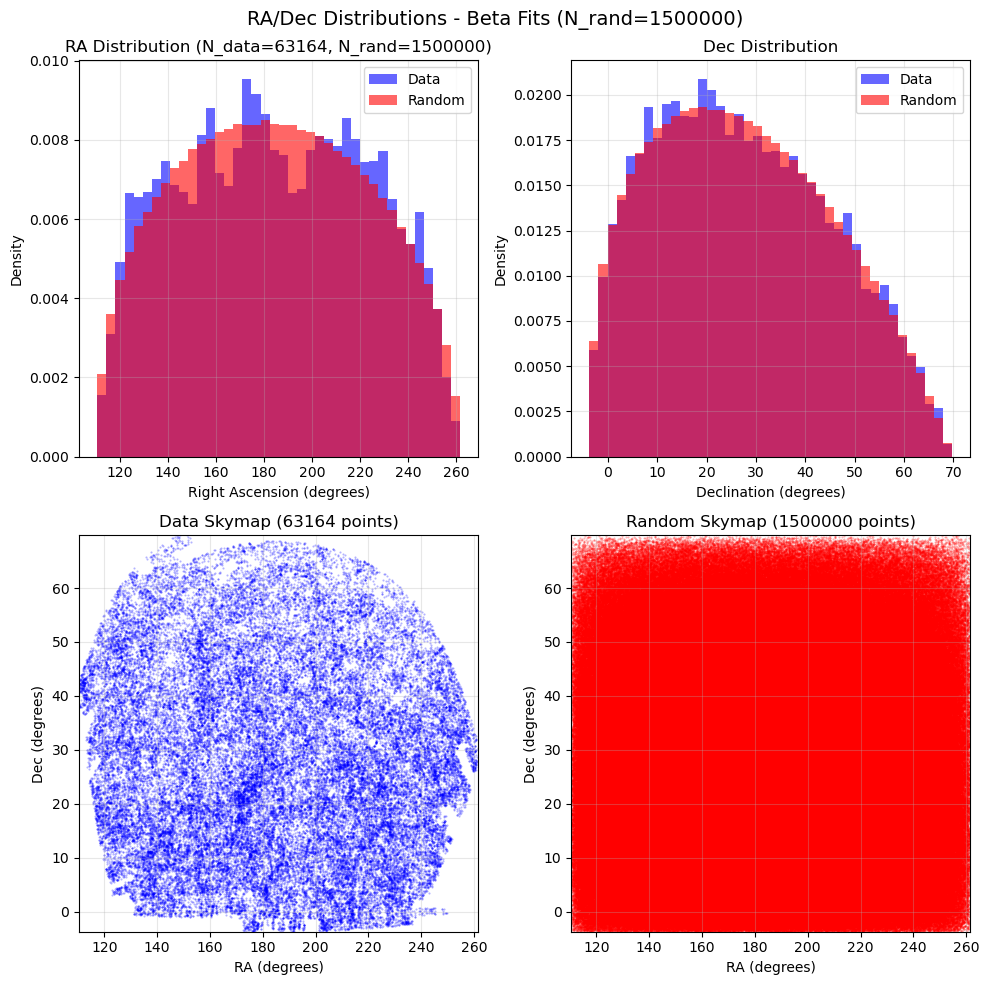


✅ Saved 1500000 random points to 'random_catalog_beta_N1500000.csv'


In [ ]:
"""
Create random distribution following Beta fits for RA and Dec from data
Assumes RA and Dec are independent
"""

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ---- Parameters ----
sample = 'nyu'
h = 0.6774  # Hubble constant
zmin, zmax = 0.07, 0.2  # Redshift range
mag_max = -21.2
gr_min = 0.8

# Size of random distribution to generate
N_random = int(1.5e6) # You can change this value


def load_catalog(sample_name: str) -> pd.DataFrame:
    """Load the requested SDSS-like catalog."""
    if sample_name == "nyu":
        datafile = "../data/sdss_dr72safe0_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    elif sample_name == "sdss":
        datafile = "../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    else:
        raise ValueError("Invalid sample")

    cat = pd.read_csv(datafile)
    cat["dist_fil"] /= h
    if gr_min != 0:
        cat = cat[cat["gr"] > gr_min]
    return cat


def select_sample(cat: pd.DataFrame) -> pd.DataFrame:
    """Apply redshift and magnitude cuts."""
    cat_z = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
    if sample == "nyu":
        cat_z_mag = cat_z[cat_z["mag_abs_r"] < mag_max].copy()
    else:
        cat_z_mag = cat_z[cat_z["mag_abs_r"] - 5 * np.log10(h) < mag_max].copy()
    return cat_z_mag


def fit_beta_distribution(data):
    """
    Fit a Beta distribution to the data.
    
    Returns:
    --------
    function : Inverse CDF function for generating random samples
    tuple : (alpha, beta) fitted parameters
    tuple : (min, max) data range
    """
    # Normalize data to [0, 1] range
    data_min, data_max = data.min(), data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    
    # Add small epsilon to avoid 0 and 1 values
    eps = 1e-6
    data_norm = np.clip(data_norm, eps, 1 - eps)
    
    # Fit Beta distribution
    a, b, loc, scale = stats.beta.fit(data_norm, floc=0, fscale=1)
    
    def inv_cdf(u):
        """Inverse CDF for generating samples."""
        samples_norm = stats.beta.ppf(u, a, b)
        return data_min + samples_norm * (data_max - data_min)
    
    return inv_cdf, (a, b), (data_min, data_max)


def generate_random_points(n_points, ra_inv_cdf, dec_inv_cdf):
    """
    Generate random RA/Dec points using Beta distributions.
    """
    # Generate RA using inverse transform sampling
    u_ra = np.random.uniform(0, 1, n_points)
    ra_random = ra_inv_cdf(u_ra)
    
    # Generate Dec using inverse transform sampling
    u_dec = np.random.uniform(0, 1, n_points)
    dec_random = dec_inv_cdf(u_dec)
    
    return ra_random, dec_random


# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Load and select data
    cat_full = load_catalog(sample)
    cat_selected = select_sample(cat_full)
    
    # Extract RA and Dec
    ra_data = cat_selected["ra"].values
    dec_data = cat_selected["dec"].values
    
    N_data = len(ra_data)
    print(f"Data size: {N_data} points")
    print(f"Generating {N_random} random points")
    print(f"RA range: [{ra_data.min():.2f}, {ra_data.max():.2f}]")
    print(f"Dec range: [{dec_data.min():.2f}, {dec_data.max():.2f}]")
    
    # Fit Beta distributions
    ra_inv_cdf, ra_params, ra_range = fit_beta_distribution(ra_data)
    dec_inv_cdf, dec_params, dec_range = fit_beta_distribution(dec_data)
    
    print(f"\nRA Beta fit: α={ra_params[0]:.3f}, β={ra_params[1]:.3f}")
    print(f"Dec Beta fit: α={dec_params[0]:.3f}, β={dec_params[1]:.3f}")
    
    # Generate random points
    ra_random, dec_random = generate_random_points(N_random, ra_inv_cdf, dec_inv_cdf)
    
    # Create plots
    fig = plt.figure(figsize=(10, 10))
    
    # RA histogram
    ax1 = plt.subplot(2, 2, 1)
    ax1.hist(ra_data, bins=40, density=True, alpha=0.6, color='blue', label='Data')
    ax1.hist(ra_random, bins=40, density=True, alpha=0.6, color='red', label='Random')
    ax1.set_xlabel('Right Ascension (degrees)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'RA Distribution (N_data={N_data}, N_rand={N_random})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Dec histogram
    ax2 = plt.subplot(2, 2, 2)
    ax2.hist(dec_data, bins=40, density=True, alpha=0.6, color='blue', label='Data')
    ax2.hist(dec_random, bins=40, density=True, alpha=0.6, color='red', label='Random')
    ax2.set_xlabel('Declination (degrees)')
    ax2.set_ylabel('Density')
    ax2.set_title('Dec Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Skymap - Data
    ax4 = plt.subplot(2, 2, 3)
    scatter4 = ax4.scatter(ra_data, dec_data, s=1, alpha=0.3, c='blue', marker='.')
    ax4.set_xlabel('RA (degrees)')
    ax4.set_ylabel('Dec (degrees)')
    ax4.set_title(f'Data Skymap ({N_data} points)')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(ra_range[0], ra_range[1])
    ax4.set_ylim(dec_range[0], dec_range[1])
    
    # Skymap - Random
    ax5 = plt.subplot(2, 2, 4)
    scatter5 = ax5.scatter(ra_random, dec_random, s=1, alpha=0.3, c='red', marker='.')
    ax5.set_xlabel('RA (degrees)')
    ax5.set_ylabel('Dec (degrees)')
    ax5.set_title(f'Random Skymap ({N_random} points)')
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(ra_range[0], ra_range[1])
    ax5.set_ylim(dec_range[0], dec_range[1])
    
    
    plt.suptitle(f'RA/Dec Distributions - Beta Fits (N_rand={N_random})', fontsize=14)
    plt.tight_layout()
    plt.savefig('ra_dec_beta_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save random catalog
    random_cat = pd.DataFrame({
        'ra': ra_random,
        'dec': dec_random,
        'type': ['random'] * N_random
    })
    filename = f'random_catalog_beta_N{N_random}.csv'
    #random_cat.to_csv(filename, index=False)
    #print(f"\n✅ Saved {N_random} random points to '{filename}'")


Data size: 63164 points
Generating 1500000 random points
RA range: [110.50, 261.55]
Dec range: [-3.75, 69.78]

RA Beta fit: α=1.460, β=1.535
Dec Beta fit: α=1.430, β=1.927


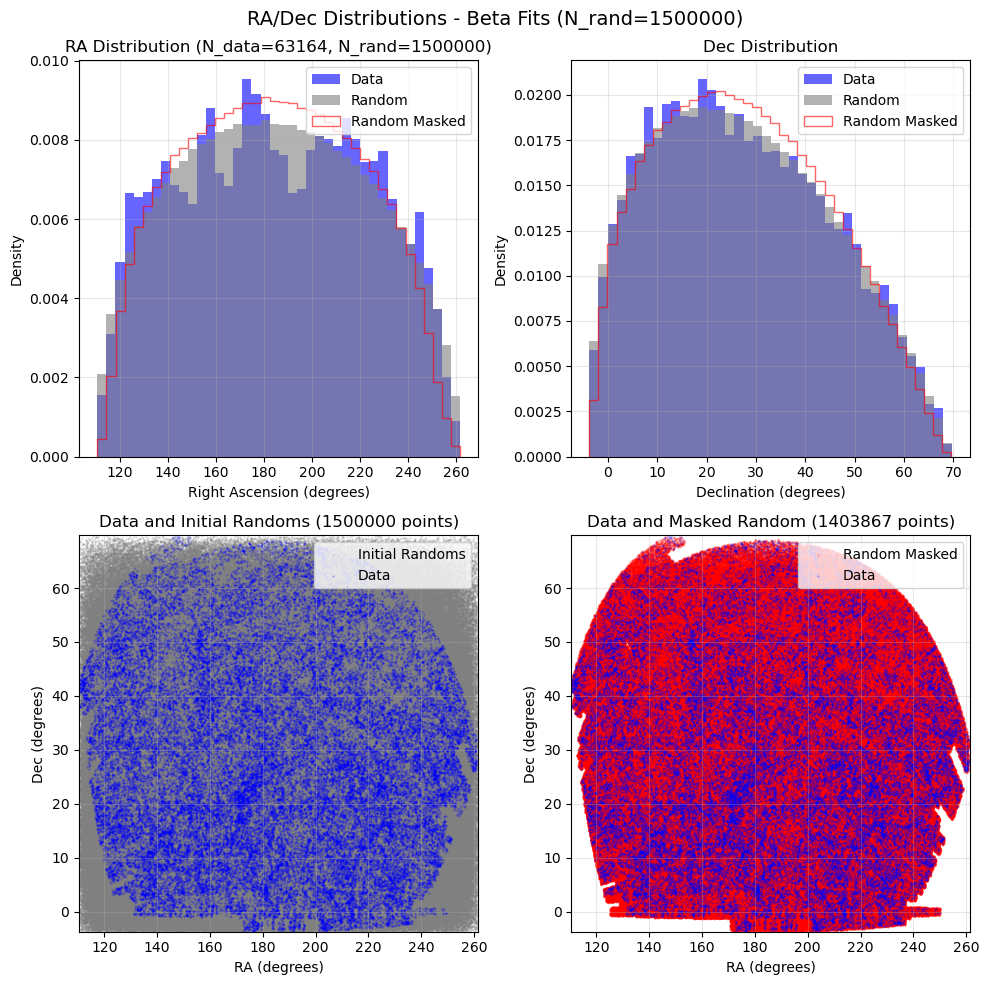


✅ Saved 1403867 random points to '../data/random_catalog_beta_N1500000_nside256.csv'


In [20]:
"""
Create random distribution following Beta fits for RA and Dec from data
Assumes RA and Dec are independent
Apply healpy mask to generated random points to match file randoms footprint
"""

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ---- Parameters ----
sample = 'nyu'
h = 0.6774  # Hubble constant
zmin, zmax = 0.07, 0.2  # Redshift range
mag_max = -21.2
gr_min = 0.8

# Size of random distribution to generate
N_random = int(1.5e6) # You can change this value


def load_catalog(sample_name: str) -> pd.DataFrame:
    """Load the requested SDSS-like catalog."""
    if sample_name == "nyu":
        datafile = "../data/sdss_dr72safe0_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    elif sample_name == "sdss":
        datafile = "../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    else:
        raise ValueError("Invalid sample")

    cat = pd.read_csv(datafile)
    cat["dist_fil"] /= h
    if gr_min != 0:
        cat = cat[cat["gr"] > gr_min]
    return cat


def select_sample(cat: pd.DataFrame) -> pd.DataFrame:
    """Apply redshift and magnitude cuts."""
    cat_z = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
    if sample == "nyu":
        cat_z_mag = cat_z[cat_z["mag_abs_r"] < mag_max].copy()
    else:
        cat_z_mag = cat_z[cat_z["mag_abs_r"] - 5 * np.log10(h) < mag_max].copy()
    return cat_z_mag


def fit_beta_distribution(data):
    """
    Fit a Beta distribution to the data.
    
    Returns:
    --------
    function : Inverse CDF function for generating random samples
    tuple : (alpha, beta) fitted parameters
    tuple : (min, max) data range
    """
    # Normalize data to [0, 1] range
    data_min, data_max = data.min(), data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    
    # Add small epsilon to avoid 0 and 1 values
    eps = 1e-6
    data_norm = np.clip(data_norm, eps, 1 - eps)
    
    # Fit Beta distribution
    a, b, loc, scale = stats.beta.fit(data_norm, floc=0, fscale=1)
    
    def inv_cdf(u):
        """Inverse CDF for generating samples."""
        samples_norm = stats.beta.ppf(u, a, b)
        return data_min + samples_norm * (data_max - data_min)
    
    return inv_cdf, (a, b), (data_min, data_max)


def generate_random_points(n_points, ra_inv_cdf, dec_inv_cdf):
    """
    Generate random RA/Dec points using Beta distributions.
    """
    # Generate RA using inverse transform sampling
    u_ra = np.random.uniform(0, 1, n_points)
    ra_random = ra_inv_cdf(u_ra)
    
    # Generate Dec using inverse transform sampling
    u_dec = np.random.uniform(0, 1, n_points)
    dec_random = dec_inv_cdf(u_dec)

    return ra_random, dec_random

def mask_from_filerandoms(ra_random, dec_random, filerandoms, nside=64):
    """
    Apply a mask to the generated random points based on the footprint of the provided random catalog.
    
    Parameters:
    -----------
    ra_random : array-like
        Generated RA values
    dec_random : array-like
        Generated Dec values
    filerandoms : str
        Path to the random catalog file (CSV) with 'ra' and 'dec' columns
    
    Returns:
    --------
    tuple : (ra_masked, dec_masked) masked RA and Dec arrays
    """
    import healpy as hp

    # Load random catalog for footprint
    random_cat = pd.read_csv(filerandoms)
    ra = random_cat['ra'].values
    dec = random_cat['dec'].values
    
    npix = hp.nside2npix(nside)
    mask = np.zeros(npix, dtype=int)

    theta = np.radians(90.0 - dec)
    phi = np.radians(ra)
    pixels = hp.ang2pix(nside, theta, phi)

    mask[pixels] = 1

    theta_random = np.radians(90.0 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)
    valid_indices = mask[random_pixels] == 1


    return ra_random[valid_indices], dec_random[valid_indices]

# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Set nside
    nside = 256  

    # Load and select data
    cat_full = load_catalog(sample)
    cat_selected = select_sample(cat_full)
    
    # Extract RA and Dec
    ra_data = cat_selected["ra"].values
    dec_data = cat_selected["dec"].values
    
    N_data = len(ra_data)
    print(f"Data size: {N_data} points")
    print(f"Generating {N_random} random points")
    print(f"RA range: [{ra_data.min():.2f}, {ra_data.max():.2f}]")
    print(f"Dec range: [{dec_data.min():.2f}, {dec_data.max():.2f}]")
    
    # Fit Beta distributions
    ra_inv_cdf, ra_params, ra_range = fit_beta_distribution(ra_data)
    dec_inv_cdf, dec_params, dec_range = fit_beta_distribution(dec_data)
    
    print(f"\nRA Beta fit: α={ra_params[0]:.3f}, β={ra_params[1]:.3f}")
    print(f"Dec Beta fit: α={dec_params[0]:.3f}, β={dec_params[1]:.3f}")
    
    # Generate random points
    ra_random, dec_random = generate_random_points(N_random, ra_inv_cdf, dec_inv_cdf)
    
    # Apply mask from random catalog footprint
    filerandoms = "../data/lss_randoms_combined_cut.csv"  # Path to your random catalog file
    ra_random_masked, dec_random_masked = mask_from_filerandoms(ra_random, dec_random, filerandoms, nside=nside)

    # Create plots
    fig = plt.figure(figsize=(10, 10))
    
    # Set density
    density = True

    # RA histogram
    ax1 = plt.subplot(2, 2, 1)
    ax1.hist(ra_data, bins=40, density=density, alpha=0.6, color='blue', label='Data')
    ax1.hist(ra_random, bins=40, density=density, alpha=0.6, color='gray', label='Random')
    ax1.hist(ra_random_masked, bins=40, density=density, alpha=0.6, color='red', histtype='step', lw=2, label='Random Masked')
    ax1.set_xlabel('Right Ascension (degrees)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'RA Distribution (N_data={N_data}, N_rand={N_random})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Dec histogram
    ax2 = plt.subplot(2, 2, 2)
    ax2.hist(dec_data, bins=40, density=density, alpha=0.6, color='blue', label='Data')
    ax2.hist(dec_random, bins=40, density=density, alpha=0.6, color='gray', label='Random')
    ax2.hist(dec_random_masked, bins=40, density=density, alpha=0.6, color='red', histtype='step', lw=2, label='Random Masked')
    ax2.set_xlabel('Declination (degrees)')
    ax2.set_ylabel('Density')
    ax2.set_title('Dec Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Skymap - Initial Randoms
    ax4 = plt.subplot(2, 2, 3)
    scatter4 = ax4.scatter(ra_random, dec_random, s=1, alpha=0.3, c='gray', marker='.', label='Initial Randoms')
    ax4.scatter(ra_data, dec_data, s=1, alpha=0.3, c='blue', marker='.', label='Data')
    ax4.set_xlabel('RA (degrees)')
    ax4.set_ylabel('Dec (degrees)')
    ax4.set_title(f'Data and Initial Randoms ({N_random} points)')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(ra_range[0], ra_range[1])
    ax4.set_ylim(dec_range[0], dec_range[1])
    ax4.legend(loc='upper right')
    
    # Skymap - Random
    ax5 = plt.subplot(2, 2, 4)
    scatter5 = ax5.scatter(ra_random_masked, dec_random_masked, s=1, alpha=0.3, c='red', marker='.', label='Random Masked')
    scatter6 = ax5.scatter(ra_data, dec_data, s=1, alpha=0.3, c='blue', marker='.', label='Data')
    ax5.set_xlabel('RA (degrees)')
    ax5.set_ylabel('Dec (degrees)')
    ax5.set_title(f'Data and Masked Random ({len(ra_random_masked)} points)')
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(ra_range[0], ra_range[1])
    ax5.set_ylim(dec_range[0], dec_range[1])
    ax5.legend(loc='upper right')
    
    plt.suptitle(f'RA/Dec Distributions - Beta Fits (N_rand={N_random})', fontsize=14)
    plt.tight_layout()
    plt.savefig('ra_dec_beta_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save random catalog
    random_cat = pd.DataFrame({
        'ra': ra_random_masked,
        'dec': dec_random_masked,
        'type': ['random'] * len(ra_random_masked)
    })
    filename = f'../data/random_catalog_beta_N{N_random}_nside{nside}.csv'
    random_cat.to_csv(filename, index=False)
    print(f"\n✅ Saved {len(ra_random_masked)} random points to '{filename}'")


Loading data catalog...
Data size: 63164 points
Data Dec range: [-3.75, 69.78]

Dec Beta fit: α=1.430, β=1.927

Loading random distribution from: ../data/lss_randoms_combined_cut.csv
Random file size: 3531535 points
Original RA range: [109.75, 261.85]
Original Dec range: [-3.75, 70.29]

Modifying Dec to match data beta distribution...
Modified Dec range: [-3.75, 69.75]

✅ Saved modified catalog to: ../data/lss_randoms_combined_cut_modified.csv


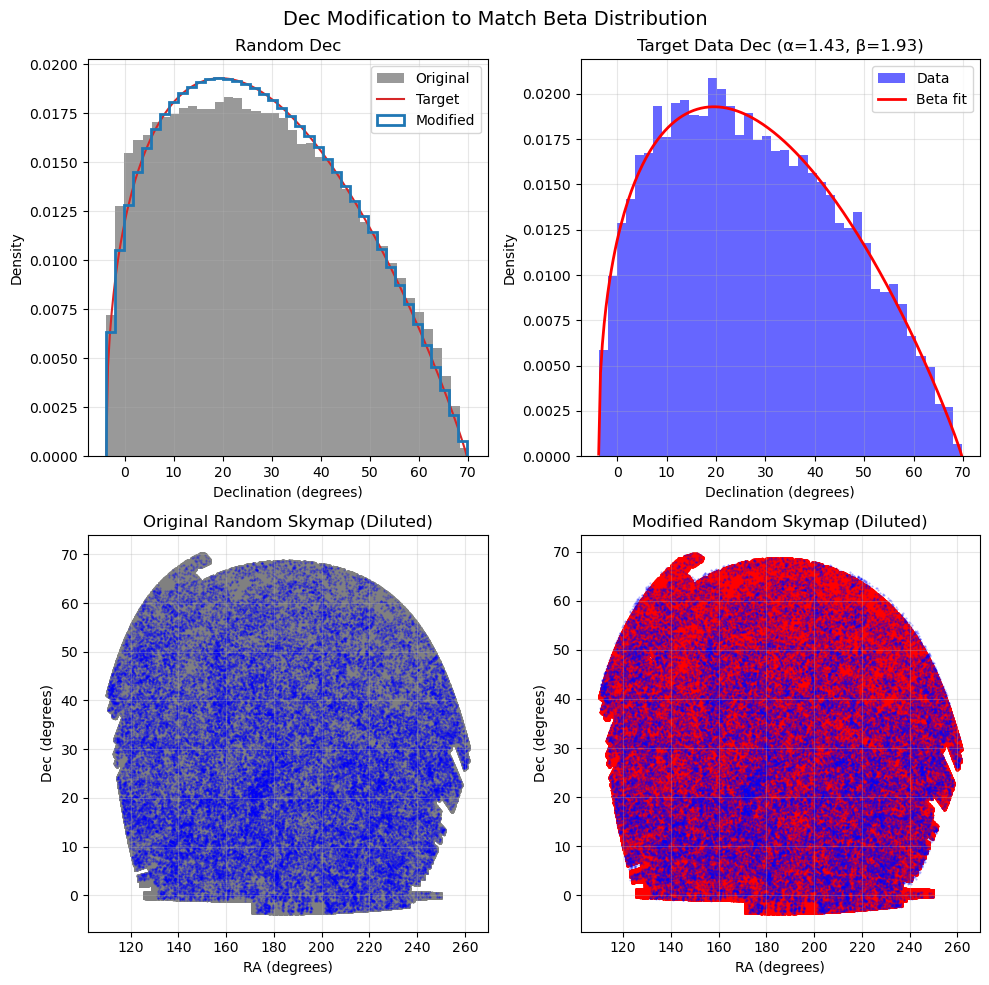


SUMMARY
Original random Dec: mean=27.76°, std=18.09°
Modified random Dec: mean=27.58°, std=17.42°
Target data Dec: mean=27.50°, std=17.47°

Transformation method: Preserved rank order (monotonic transformation)
This keeps the same relative ordering but changes the distribution shape


In [ ]:
"""
Read existing random distribution and modify only Dec to match data's beta fit
"""

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# ---- Parameters ----
sample = 'nyu'
h = 0.6774  # Hubble constant
zmin, zmax = 0.07, 0.2  # Redshift range
mag_max = -21.2
gr_min = 0.8

# Input/output files
input_random_file = '../data/lss_randoms_combined_cut.csv'  # Filepath for RA/Dec if read_RADec is True
output_file = "../data/lss_randoms_combined_cut_modified.csv"

# Columns in your random file (adjust these to match your file)
ra_col = "ra"      # Name of RA column
dec_col = "dec"    # Name of Dec column


def load_catalog(sample_name: str) -> pd.DataFrame:
    """Load the requested SDSS-like catalog."""
    if sample_name == "nyu":
        datafile = "../data/sdss_dr72safe0_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    elif sample_name == "sdss":
        datafile = "../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv"
    else:
        raise ValueError("Invalid sample")

    cat = pd.read_csv(datafile)
    cat["dist_fil"] /= h
    if gr_min != 0:
        cat = cat[cat["gr"] > gr_min]
    return cat


def select_sample(cat: pd.DataFrame) -> pd.DataFrame:
    """Apply redshift and magnitude cuts."""
    cat_z = cat[(cat["red"] >= zmin) & (cat["red"] <= zmax)]
    if sample == "nyu":
        cat_z_mag = cat_z[cat_z["mag_abs_r"] < mag_max].copy()
    else:
        cat_z_mag = cat_z[cat_z["mag_abs_r"] - 5 * np.log10(h) < mag_max].copy()
    return cat_z_mag


def fit_beta_distribution(data):
    """
    Fit a Beta distribution to the data.
    
    Returns:
    --------
    function : Inverse CDF function for generating samples
    tuple : (alpha, beta) fitted parameters
    tuple : (min, max) data range
    """
    # Normalize data to [0, 1] range
    data_min, data_max = data.min(), data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    
    # Add small epsilon to avoid 0 and 1 values
    eps = 1e-6
    data_norm = np.clip(data_norm, eps, 1 - eps)
    
    # Fit Beta distribution
    a, b, loc, scale = stats.beta.fit(data_norm, floc=0, fscale=1)
    
    def inv_cdf(u):
        """Inverse CDF for generating samples."""
        samples_norm = stats.beta.ppf(u, a, b)
        return data_min + samples_norm * (data_max - data_min)
    
    def pdf(x):
        """PDF for visualization."""
        x_norm = (x - data_min) / (data_max - data_min)
        x_norm = np.clip(x_norm, eps, 1 - eps)
        return stats.beta.pdf(x_norm, a, b) / (data_max - data_min)
    
    return inv_cdf, pdf, (a, b), (data_min, data_max)


def modify_dec_to_beta(dec_original, dec_inv_cdf, preserve_order=True):
    """
    Modify declination values to follow the target beta distribution.
    
    Parameters:
    -----------
    dec_original : array
        Original declination values
    dec_inv_cdf : function
        Inverse CDF of target beta distribution
    preserve_order : bool
        If True, preserves the rank order (monotonic transformation)
        If False, shuffles the new values
    
    Returns:
    --------
    array : Modified declination values
    """
    n = len(dec_original)
    
    if preserve_order:
        # Method 1: Preserve the order (monotonic transformation)
        # This keeps the same ranking but changes the distribution
        ranks = stats.rankdata(dec_original) / (n + 1)  # Convert to percentiles
        dec_modified = dec_inv_cdf(ranks)
    else:
        # Method 2: Don't preserve order (random reassignment)
        # Generate new random values from the target distribution
        u = np.random.uniform(0, 1, n)
        dec_modified = dec_inv_cdf(u)
    
    return dec_modified


# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # 1. Load the data to get target Dec distribution
    print("Loading data catalog...")
    cat_full = load_catalog(sample)
    cat_selected = select_sample(cat_full)
    
    # Extract Dec from data
    ra_data = cat_selected["ra"].values
    dec_data = cat_selected["dec"].values
    print(f"Data size: {len(dec_data)} points")
    print(f"Data Dec range: [{dec_data.min():.2f}, {dec_data.max():.2f}]")
    
    # 2. Fit Beta distribution to data Dec
    dec_inv_cdf, dec_pdf, dec_params, dec_range = fit_beta_distribution(dec_data)
    print(f"\nDec Beta fit: α={dec_params[0]:.3f}, β={dec_params[1]:.3f}")
    
    # 3. Load existing random distribution
    print(f"\nLoading random distribution from: {input_random_file}")
    random_df = pd.read_csv(input_random_file)
    
    # Check if required columns exist
    if ra_col not in random_df.columns:
        raise ValueError(f"RA column '{ra_col}' not found in file")
    if dec_col not in random_df.columns:
        raise ValueError(f"Dec column '{dec_col}' not found in file")
    
    ra_original = random_df[ra_col].values
    dec_original = random_df[dec_col].values
    
    print(f"Random file size: {len(random_df)} points")
    print(f"Original RA range: [{ra_original.min():.2f}, {ra_original.max():.2f}]")
    print(f"Original Dec range: [{dec_original.min():.2f}, {dec_original.max():.2f}]")
    
    # 4. Modify only Dec to match beta distribution
    print("\nModifying Dec to match data beta distribution...")
    
    # Choose method:
    # preserve_order=True: keeps the same ranking (monotonic transformation)
    # preserve_order=False: completely randomizes Dec values
    preserve_order = True  # Set to False if you want to randomize Dec
    
    dec_modified = modify_dec_to_beta(dec_original, dec_inv_cdf, preserve_order=preserve_order)
    
    # 5. Create modified catalog (keeping all original columns, updating only Dec)
    modified_df = random_df.copy()
    modified_df[dec_col] = dec_modified
    
    # Add metadata columns
    modified_df['dec_original'] = dec_original  # Keep original for reference
    modified_df['modified'] = True
    
    print(f"Modified Dec range: [{dec_modified.min():.2f}, {dec_modified.max():.2f}]")
    
    # 6. Save modified catalog
    modified_df.to_csv(output_file, index=False)
    print(f"\n✅ Saved modified catalog to: {output_file}")
    
    # 7. Visualize the transformation
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Original random Dec
    axes[0, 0].hist(dec_original, bins=40, density=True, alpha=0.8, color='gray', label='Original')
    x_dec = np.linspace(dec_range[0], dec_range[1], 200)
    axes[0, 0].plot(x_dec, dec_pdf(x_dec), c='C03', label='Beta fit')
    axes[0, 0].hist(dec_modified, bins=40, density=True, alpha=1, color='C00', label='Modified', histtype='step', linewidth=2)
    axes[0, 0].set_xlabel('Declination (degrees)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Random Dec')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Target data Dec
    axes[0, 1].hist(dec_data, bins=40, density=True, alpha=0.6, color='blue', label='Data')
    axes[0, 1].plot(x_dec, dec_pdf(x_dec), 'r-', linewidth=2, label='Beta fit')
    axes[0, 1].set_xlabel('Declination (degrees)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title(f'Target Data Dec (α={dec_params[0]:.2f}, β={dec_params[1]:.2f})')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    

    # Original skymap
    axes[1, 0].scatter(ra_original, dec_original, s=1, alpha=1, c='gray', marker='.')
    axes[1, 0].scatter(ra_data, dec_data, s=1, alpha=0.3, c='blue', marker='.', label='Data')
    axes[1, 0].set_xlabel('RA (degrees)')
    axes[1, 0].set_ylabel('Dec (degrees)')
    axes[1, 0].set_title('Original Random Skymap (Diluted)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Modified skymap
    axes[1, 1].scatter(ra_original, dec_modified, s=1, alpha=1, c='red', marker='.')
    axes[1, 1].scatter(ra_data, dec_data, s=1, alpha=0.3, c='blue', marker='.', label='Data')
    axes[1, 1].set_xlabel('RA (degrees)')
    axes[1, 1].set_ylabel('Dec (degrees)')
    axes[1, 1].set_title('Modified Random Skymap (Diluted)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Dec Modification to Match Beta Distribution', fontsize=14)
    plt.tight_layout()
    plt.savefig('dec_modification_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*50)
    print("SUMMARY")
    print("="*50)
    print(f"Original random Dec: mean={dec_original.mean():.2f}°, std={dec_original.std():.2f}°")
    print(f"Modified random Dec: mean={dec_modified.mean():.2f}°, std={dec_modified.std():.2f}°")
    print(f"Target data Dec: mean={dec_data.mean():.2f}°, std={dec_data.std():.2f}°")
    
    # Show transformation method
    if preserve_order:
        print("\nTransformation method: Preserved rank order (monotonic transformation)")
        print("This keeps the same relative ordering but changes the distribution shape")
    else:
        print("\nTransformation method: Random reassignment")
        print("This completely randomizes Dec values according to target distribution")